In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, Activation, Dropout, MaxPooling2D, BatchNormalization, Convolution2D, Input
from keras import regularizers
from keras.layers.pooling import GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.layers import LeakyReLU
from sklearn import preprocessing

from PIL import Image

Using TensorFlow backend.


### Load processed images and create train/dev split

Category:  shovel


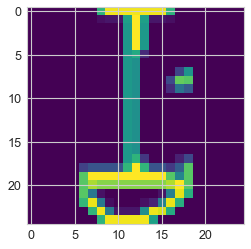

In [2]:
#Load images and labels
images = np.load('data/train_clean.npy',encoding = 'latin1')
newDims = 25
T_text = np.loadtxt('train_labels.csv', usecols=1, delimiter=',', dtype='str')
T_text = T_text[1:]

enc = preprocessing.LabelEncoder()
T = enc.fit_transform(T_text)
T = keras.utils.to_categorical(T)

X = images.reshape(len(images), newDims, newDims)
X = X/255

print('Category: ', T_text[0])
plt.imshow(X[0])

In [3]:
X_train, X_valid, T_train, T_valid = train_test_split(X, T, test_size=0.20, random_state=42)

X_train = X_train.reshape(len(X_train), newDims, newDims, 1)
X_valid = X_valid.reshape(len(X_valid), newDims, newDims, 1)

### Simple Keras CNN

In [4]:

def createModel():    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(newDims,newDims,1)))
    model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.2))
    
    model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.3))
    
    model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.3))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.7))
    model.add(Dense(31, activation='softmax'))
    
    return model

adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model1 = createModel()
model1.compile(optimizer=adam , loss='categorical_crossentropy', metrics=['accuracy'])
 
#Weight saving
filepath1 = "weights/weights.hdf5"
#model1.load_weights("weights.hdf5")


checkpoint1 = ModelCheckpoint(filepath1, monitor = 'loss', verbose = 1, save_best_only = True, mode = 'auto')
callbacks_list1 = [checkpoint1] 

#Fit without Data Augmentation
#history = model1.fit(X_train, T_train, batch_size=32, epochs=100, verbose=1, 
#   validation_data=(X_valid, T_valid), shuffle=True, callbacks = callbacks_list1)
 
#model1.evaluate(X_valid, T_valid)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Train with data augmentation 

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold

batch_size = 32

gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = False, 
                         width_shift_range = 4,
                         height_shift_range = 4,
                         zoom_range = 0.01,
                         rotation_range = 0
                        )

generator = gen.flow(X_train, T_train, batch_size = batch_size)

history = model1.fit_generator(
    generator,
    steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
                epochs=1,
                shuffle=True,
                verbose=1,
                validation_data = (X_valid, T_valid),
                callbacks = callbacks_list1
)


Epoch 1/1
250/250 [==============================] - 2s 9ms/step - loss: 0.8504 - acc: 0.7517 - val_loss: 0.8458 - val_acc: 0.7720

Epoch 00001: loss did not improve from 0.80801


In [8]:
T_train_pred = model1.predict(X_train)
T_train_pred = np.argmax(T_train_pred, axis=1)
T_train_true = np.argmax(T_train, axis=1)


T_valid_pred = model1.predict(X_valid)
T_valid_pred = np.argmax(T_valid_pred, axis=1)
T_valid_true = np.argmax(T_valid, axis=1)

print('Training Accuracy : \t', accuracy_score(T_train_true, T_train_pred))
print('Validation Accuracy : \t', accuracy_score(T_valid_true, T_valid_pred))

Training Accuracy : 	 0.864
Validation Accuracy : 	 0.772


### Extract HoG features

In [10]:
from skimage.transform import resize
newDims = 50
newX = np.zeros((len(X), newDims, newDims))
for i in range(len(X)) :       
    newX[i] = resize(X[i],(newDims,newDims), mode='constant')

In [ ]:
from skimage.feature import hog

ppc = 2
X_hog, hog_features = [], []
for image in newX:
    fd, hog_image = hog(image, orientations=10, pixels_per_cell=(ppc,ppc),cells_per_block=(5, 5),block_norm= 'L2',visualize=True)
    X_hog.append(hog_image)
    hog_features.append(fd)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


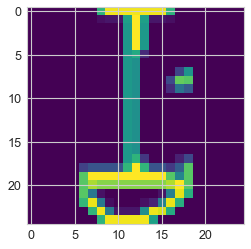

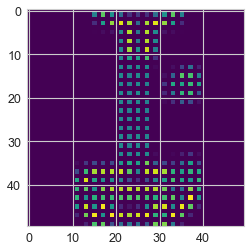

In [38]:
plt.imshow(X[0])
plt.show()
plt.imshow(X_hog[0])
plt.show()b